# Population Forecast for Children Aged 0–6 Years in Berlin

This notebook is part of the **"KitaMap Berlin"** project and demonstrates how historical child numbers per district are processed, analyzed, and projected using various time series models. The goal is to derive reliable forecasts for the development of child numbers (0–6 years) up to 2034. These data feed into the overall view of the supply situation with daycare places and thus form an important basis for needs-based planning and decisions.

## Main Tasks of the Notebook:

1. **Data Integration and Historical Analysis**  
   - Import and filter data on child numbers (years 2015–2024)  
   - Initial visual analysis to illustrate trends in the districts

2. **Model Selection and Forecast Creation**  
   - Application of various forecasting models (Exponential Smoothing, Prophet)  
   - Development of a combined ensemble model to improve accuracy

3. **Model Evaluation and Result Preparation**  
   - Calculation of error metrics (RMSE, MAE, MAPE) for objective model assessment  
   - Transfer of final forecast values into a structured dataset and CSV export  
   - Visualization to directly compare historical and forecasted developments

These forecast results support the planning of daycare capacities by providing early indications of potential bottlenecks or increasing demand in certain districts. Thus, the notebook makes a significant contribution to the forward-looking design of Berlin's daycare landscape.


In [ ]:
# Import necessary libraries  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configure constants
INPUT_PATH = Path("../data/raw/population_development_2015_2024.csv")
OUTPUT_PATH = Path("../data/processed/population_forecast_2024_2034.csv")

## Development of Child Numbers (2015–2024) and Framework for Forecasts

In this section, the historically recorded child numbers (0–6 years) per Berlin district are read from a CSV file, visually processed, and prepared for further forecasts:

1. **Data Import**  
   The CSV data are filtered so that only the district name and the annual values from 2015 to 2024 remain.

2. **Visualization**  
   A line chart shows the temporal development of child numbers per district. Different colored lines and an external legend provide a clear comparison between the districts.

3. **Forecast Framework**  
   For the future years (2024, 2029, 2034, 2039), a new DataFrame is created. The values for 2024 are taken directly from the historical data as a starting point. This creates an initial framework for the later projection of child numbers.


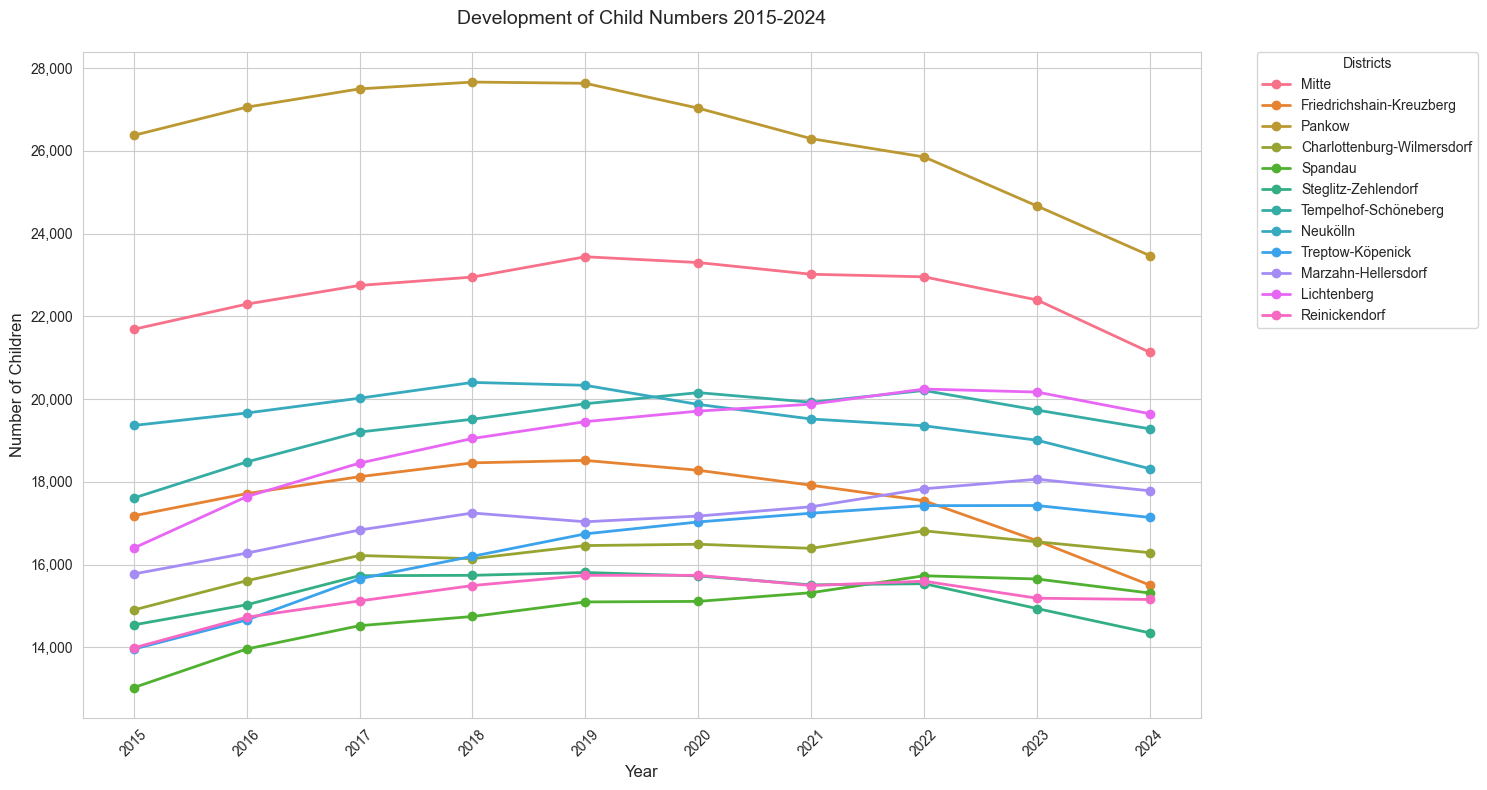


Results DataFrame Structure:
                             2024 2029 2034
Bezirk                                     
Mitte                       21130  NaN  NaN
Friedrichshain-Kreuzberg    15504  NaN  NaN
Pankow                      23466  NaN  NaN
Charlottenburg-Wilmersdorf  16288  NaN  NaN
Spandau                     15312  NaN  NaN
Steglitz-Zehlendorf         14349  NaN  NaN
Tempelhof-Schöneberg        19281  NaN  NaN
Neukölln                    18317  NaN  NaN
Treptow-Köpenick            17140  NaN  NaN
Marzahn-Hellersdorf         17784  NaN  NaN
Lichtenberg                 19646  NaN  NaN
Reinickendorf               15157  NaN  NaN


In [3]:
# Load historical data
df = pd.read_csv(INPUT_PATH)
year_columns = [str(year) for year in range(2015, 2025)]  # Years from 2015-2024
df = df[['Bezirk'] + year_columns]  # District + years in chronological order

# Plotting Setup
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create a nice color palette for the districts
colors = sns.color_palette("husl", n_colors=len(df))

# Plot for each district
for idx, row in df.iterrows():
    district = row['Bezirk']
    values = row[year_columns].values  # Now we can directly take the values
    plt.plot(year_columns, values, marker='o', label=district, color=colors[idx], linewidth=2)

# Plot Layout
plt.title('Development of Child Numbers 2015-2024', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Children', fontsize=12)
plt.xticks(rotation=45)

# Add thousand separators to the Y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), 
            loc='upper left', 
            borderaxespad=0.,
            title='Districts',
            frameon=True)

plt.tight_layout()
plt.show()

# Create results DataFrame with districts as index and forecast years as columns
forecast_years = [2024, 2029, 2034]
results = pd.DataFrame(index=df['Bezirk'], columns=forecast_years)

# Fill in 2024 values
results[2024] = df['2024'].values

print("\nResults DataFrame Structure:")
print(results)

## Forecast Error Metrics and Model Evaluation

In this section, three functions are first defined to quantify forecast errors. These metrics enable an objective evaluation of different forecasting models:

1. **RMSE (Root Mean Squared Error)**  
   Provides the average deviation of the forecasts squared by taking the square root of the mean of the squared errors.

2. **MAE (Mean Absolute Error)**  
   Indicates the average deviation of the forecasts in absolute terms.

3. **MAPE (Mean Absolute Percentage Error)**  
   Measures the percentage deviation between predicted and actual values, showing how many percent the model is off on average.

Additionally, the target years for the forecasts (2029, 2034, 2039) are defined and recorded in a new DataFrame **all_predictions**. This DataFrame serves as a structured overview for the forecast results of the three models **ETS**, **Prophet**, and **Ensemble**.  

Finally, a function **evaluate_model** is defined, which compares the predicted values of a model for a specific district with the actual values and calculates the above error metrics. The results are summarized in a dictionary and can then be used for comparisons and evaluations.


In [4]:
def calculate_rmse(y_true, y_pred):
    # Calculate the root mean squared error
    return sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    # Calculate the mean absolute error
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    # Calculate the mean absolute percentage error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model_name, y_true, y_pred, bezirk):
    # Evaluate the model performance
    return {
        'Model': model_name,
        'Bezirk': bezirk,
        'RMSE': calculate_rmse(y_true, y_pred),
        'MAE': calculate_mae(y_true, y_pred),
        'MAPE': calculate_mape(y_true, y_pred)
    }

In [5]:
# Define forecast years
forecast_years = [2029, 2034]

# Initialize DataFrame for all predictions
all_predictions = pd.DataFrame(
    index=df['Bezirk'],
    columns=[
        f'{model}_{year}' 
        for model in ['ETS', 'Prophet', 'Ensemble'] 
        for year in forecast_years
    ]
)

evaluation_results = []

## Exponential Smoothing Forecast and Model Evaluation

In this section, the Exponential Smoothing method is applied to the child numbers of all Berlin districts. For each district, the data are first split into training data (all but the last two values) and test data (the last two values). The model is then trained and creates a forecast for 16 future time points, from which the values for the defined forecast years (e.g., 2029, 2034, 2039) are taken.  

For evaluation, a separate model is fitted again with the training data and applied to the test data. The forecast quality is determined using the previously defined metrics **RMSE**, **MAE**, and **MAPE** to enable an objective comparison between predicted and actual values. The results are summarized in a DataFrame and grouped by the mean of all error metrics.


In [6]:
# Exponential Smoothing for each district
for district in df['Bezirk']:
    # Prepare historical data - now in correct chronological order
    historical_values = df[df['Bezirk'] == district][year_columns].values.flatten()
    
    # Train-Test-Split for evaluation
    train_data = historical_values[:-2]
    test_data = historical_values[-2:]
    
    # Exponential Smoothing forecast
    exp_model = ExponentialSmoothing(
        historical_values, trend='add', seasonal=None, damped_trend=True
    ).fit()
    exp_forecast = exp_model.forecast(16)
    
    # Save the ETS forecasts
    for i, year in enumerate(forecast_years):
        all_predictions.loc[district, f'ETS_{year}'] = np.round(exp_forecast[4 + i*5], 0)
    
    # Evaluation
    exp_model_eval = ExponentialSmoothing(
        train_data, trend='add', seasonal=None, damped_trend=True
    ).fit()
    exp_pred_eval = exp_model_eval.forecast(2)
    evaluation_results.append(
        evaluate_model('Exponential Smoothing', test_data, exp_pred_eval, district)
    )

# Display results for ETS
print("\nExponential Smoothing forecasts:")
print(all_predictions.filter(like='ETS'))
print("\nETS Evaluation:")
ets_eval = pd.DataFrame(evaluation_results)
print(ets_eval.groupby('Model')[['RMSE', 'MAE', 'MAPE']].mean())


Exponential Smoothing forecasts:
                           ETS_2029 ETS_2034
Bezirk                                      
Mitte                       20567.0  20000.0
Friedrichshain-Kreuzberg    14171.0  12896.0
Pankow                      21427.0  19566.0
Charlottenburg-Wilmersdorf  17425.0  18024.0
Spandau                     17022.0  18075.0
Steglitz-Zehlendorf         13916.0  13497.0
Tempelhof-Schöneberg        19616.0  19803.0
Neukölln                    17352.0  16450.0
Treptow-Köpenick            18523.0  19815.0
Marzahn-Hellersdorf         19110.0  20066.0
Lichtenberg                 19551.0  19509.0
Reinickendorf               15218.0  15256.0

ETS Evaluation:
                             RMSE        MAE      MAPE
Model                                                 
Exponential Smoothing  735.412781  676.52866  3.778959


## Prophet-Vorhersage und Modellbewertung

Auch für das **Prophet**-Modell wird zunächst die zeitliche Entwicklung der Kinderzahlen pro Bezirk herangezogen. Ausgehend von den historischen Werten (2015–2024) werden entsprechende Zeitstempel erstellt, die Prophet als Eingabe dienen. Danach wird das Modell trainiert und für die definierten Vorhersagejahre (etwa 2029, 2034 und 2039) eine Prognose erzeugt.

Für die Evaluierung wird das Modell auf einen verkürzten Datensatz (ohne die letzten beiden Werte) fitten und die Performance anhand der verbleibenden zwei Testpunkte messen. Die vorhergesagten Werte werden mit den tatsächlichen verglichen und durch **RMSE**, **MAE** und **MAPE** quantifiziert. Abschließend fasst ein DataFrame die Fehlermetriken je Bezirk zusammen, was einen direkten Vergleich der Modellgenauigkeit ermöglicht.


In [7]:
# Prophet for each district
for district in df['Bezirk']:
    # Extract historical data - and flatten() to make it 1-dimensional
    historical_values = df[df['Bezirk'] == district][year_columns].values.flatten()
    
    # Create date range
    dates = pd.date_range(start='2015', periods=len(year_columns), freq='Y')
    
    # Prepare data for Prophet
    prophet_df = pd.DataFrame({
        'ds': dates,
        'y': historical_values
    })
    
    # Fit model and make forecast
    prophet_model = Prophet(yearly_seasonality=False)
    prophet_model.fit(prophet_df)
    
    # Create future data
    future = pd.DataFrame({
        'ds': [pd.Timestamp(str(year)) for year in forecast_years]
    })
    prophet_forecast = prophet_model.predict(future)
    
    # Extract forecasts for the desired years
    for year in forecast_years:
        forecast_value = prophet_forecast[prophet_forecast['ds'].dt.year == year]['yhat'].values[0]
        all_predictions.loc[district, f'Prophet_{year}'] = np.round(forecast_value, 0)
    
    # Evaluation
    train_data = historical_values[:-2]
    test_data = historical_values[-2:]
    
    # Prepare evaluation dataset
    train_dates = dates[:-2]
    prophet_df_eval = pd.DataFrame({
        'ds': train_dates,
        'y': train_data
    })
    
    # Fit evaluation model
    prophet_model_eval = Prophet(yearly_seasonality=False)
    prophet_model_eval.fit(prophet_df_eval)
    
    # Forecast for evaluation period
    future_eval = pd.DataFrame({'ds': dates[-2:]})
    prophet_pred_eval = prophet_model_eval.predict(future_eval)['yhat'].values
    
    evaluation_results.append(
        evaluate_model('Prophet', test_data, prophet_pred_eval, district)
    )

# Display results for Prophet
print("\nProphet forecasts:")
print(all_predictions.filter(like='Prophet'))
print("\nProphet Evaluation:")
prophet_eval = pd.DataFrame(evaluation_results)
print(prophet_eval[prophet_eval['Model'] == 'Prophet'].groupby('Model')[['RMSE', 'MAE', 'MAPE']].mean())

09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:11 - cmdstanpy - INFO - Chain [1] done processing
09:43:12 - cmdstanpy - INFO - Chain [1] start processing
09:43:12 - cmdstanpy - INFO - Chain [1]


Prophet forecasts:
                           Prophet_2029 Prophet_2034
Bezirk                                              
Mitte                           17963.0      13787.0
Friedrichshain-Kreuzberg        16134.0      15280.0
Pankow                          18696.0      12736.0
Charlottenburg-Wilmersdorf      15721.0      14928.0
Spandau                         15010.0      14490.0
Steglitz-Zehlendorf             11967.0       8995.0
Tempelhof-Schöneberg            17718.0      15724.0
Neukölln                        16620.0      14380.0
Treptow-Köpenick                16676.0      16022.0
Marzahn-Hellersdorf             18648.0      19462.0
Lichtenberg                     18781.0      17564.0
Reinickendorf                   14434.0      13570.0

Prophet Evaluation:
               RMSE         MAE      MAPE
Model                                    
Prophet  669.250873  601.149788  3.371532


## Prophet Forecast and Model Evaluation

This section applies the Prophet forecasting model to the child numbers in each Berlin district. The historical data are split into training and test sets, and the model is trained to predict future values for the defined forecast years (2029, 2034, 2039).

The model's performance is evaluated using the previously defined error metrics (RMSE, MAE, MAPE), comparing the predicted values to the actual test data. Results are summarized for each district and model, providing a basis for comparison and further analysis.

In [8]:
# Method 3: Ensemble

# Calculate weights based on the performance (MAPE) of the models
ets_mape = ets_eval[ets_eval['Model'] == 'Exponential Smoothing']['MAPE'].mean()
prophet_mape = prophet_eval[prophet_eval['Model'] == 'Prophet']['MAPE'].mean()

# Use inverse MAPE for weighting
ets_weight = (1/ets_mape) / (1/ets_mape + 1/prophet_mape)
prophet_weight = (1/prophet_mape) / (1/ets_mape + 1/prophet_mape)

# Ensemble for each district
for district in df['Bezirk']:
    # Extract historical data in correct order
    historical_values = df[df['Bezirk'] == district][year_columns].values.flatten()
    dates = pd.date_range(start='2015', periods=len(year_columns), freq='Y')
    
    # Calculate ensemble forecast and save
    for year in forecast_years:
        ets_pred = all_predictions.loc[district, f'ETS_{year}']
        prophet_pred = all_predictions.loc[district, f'Prophet_{year}']
        ensemble_pred = (ets_weight * ets_pred + prophet_weight * prophet_pred)
        all_predictions.loc[district, f'Ensemble_{year}'] = np.round(ensemble_pred, 0)
    
    # Evaluation
    train_data = historical_values[:-2]
    test_data = historical_values[-2:]
    
    # ETS Evaluation
    exp_model_eval = ExponentialSmoothing(
        train_data, trend='add', seasonal=None, damped_trend=True
    ).fit()
    ets_pred_eval = exp_model_eval.forecast(2)
    
    # Prophet Evaluation
    train_dates = dates[:-2]
    prophet_df_eval = pd.DataFrame({
        'ds': train_dates,
        'y': train_data
    })
    prophet_model_eval = Prophet(yearly_seasonality=False)
    prophet_model_eval.fit(prophet_df_eval)
    future_eval = pd.DataFrame({'ds': dates[-2:]})
    prophet_pred_eval = prophet_model_eval.predict(future_eval)['yhat'].values
    
    # Ensemble Evaluation
    ensemble_pred_eval = ets_weight * ets_pred_eval + prophet_weight * prophet_pred_eval
    
    evaluation_results.append(
        evaluate_model('Ensemble', test_data, ensemble_pred_eval, district)
    )

# Display results for Ensemble
print("\nEnsemble forecasts:")
print(all_predictions.filter(like='Ensemble'))
print("\nEnsemble Evaluation:")
ensemble_eval = pd.DataFrame(evaluation_results)
print(ensemble_eval[ensemble_eval['Model'] == 'Ensemble'].groupby('Model')[['RMSE', 'MAE', 'MAPE']].mean())

# Transfer final Ensemble forecasts to results DataFrame
for year in forecast_years:
    if year == 2024:
        continue  # 2024 we already have from real data
    results[year] = all_predictions[f'Ensemble_{year}']

09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:14 - cmdstanpy - INFO - Chain [1] start processing
09:43:14 - cmdstanpy - INFO - Chain [1] done processing
09:43:15 - cmdstanpy - INFO - Chain [1] start processing
09:43:15 - cmdstanpy - INFO - Chain [1] done processing
09:43:15 - cmdstanpy - INFO - Chain [1] start processing
09:43:15 - cmdstanpy - INFO - Chain [1] done processing
09:43:15 - cmdstanpy - INFO - Chain [1] start processing
09:43:15 - cmdstanpy - INFO - Chain [1]


Ensemble forecasts:
                           Ensemble_2029 Ensemble_2034
Bezirk                                                
Mitte                            19191.0       16716.0
Friedrichshain-Kreuzberg         15208.0       14156.0
Pankow                           19984.0       15956.0
Charlottenburg-Wilmersdorf       16524.0       16388.0
Spandau                          15959.0       16180.0
Steglitz-Zehlendorf              12886.0       11118.0
Tempelhof-Schöneberg             18613.0       17647.0
Neukölln                         16965.0       15356.0
Treptow-Köpenick                 17547.0       17810.0
Marzahn-Hellersdorf              18866.0       19747.0
Lichtenberg                      19144.0       18481.0
Reinickendorf                    14804.0       14365.0

Ensemble Evaluation:
                RMSE         MAE      MAPE
Model                                     
Ensemble  699.433138  634.252971  3.550137


## Ensemble Model and Final Forecasts

In this section, an ensemble model is created by combining the results of the Exponential Smoothing and Prophet models. The ensemble approach aims to improve forecast accuracy by leveraging the strengths of both models.

The final forecasts for each district and year are calculated, and the results are exported to a CSV file for further use. Visualizations compare the historical and forecasted child numbers, providing insights into future trends and potential planning needs for daycare capacities in Berlin.

In [9]:
# Convert Evaluation Results to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Average metrics per model
print("Average metrics per model:")
print(eval_df.groupby('Model')[['RMSE', 'MAE', 'MAPE']].mean())

# Best models per district based on MAPE
print("\nBest models per district (based on MAPE):")
best_models = eval_df.loc[eval_df.groupby('Bezirk')['MAPE'].idxmin()]
print(best_models[['Bezirk', 'Model', 'MAPE']])

Average metrics per model:
                             RMSE         MAE      MAPE
Model                                                  
Ensemble               699.433138  634.252971  3.550137
Exponential Smoothing  735.412781  676.528660  3.778959
Prophet                669.250873  601.149788  3.371532

Best models per district (based on MAPE):
                        Bezirk                  Model      MAPE
15  Charlottenburg-Wilmersdorf                Prophet  2.803515
13    Friedrichshain-Kreuzberg                Prophet  6.008396
22                 Lichtenberg                Prophet  3.458186
9          Marzahn-Hellersdorf  Exponential Smoothing  1.029205
12                       Mitte                Prophet  4.235415
19                    Neukölln                Prophet  1.402531
14                      Pankow                Prophet  3.443157
23               Reinickendorf                Prophet  1.874544
4                      Spandau  Exponential Smoothing  3.006928
17        

## Summary and Outlook

This final section summarizes the main findings of the demographic forecasting analysis. The results provide valuable input for planning daycare capacities and identifying districts with potential future bottlenecks or increased demand.

The notebook demonstrates the use of time series models for population forecasting and highlights the importance of data-driven decision-making in urban planning. Future work may include refining the models, incorporating additional data sources, and extending the forecasts to other age groups or regions.


Forecast saved in: ../data/processed/prognose_2024_2034.csv


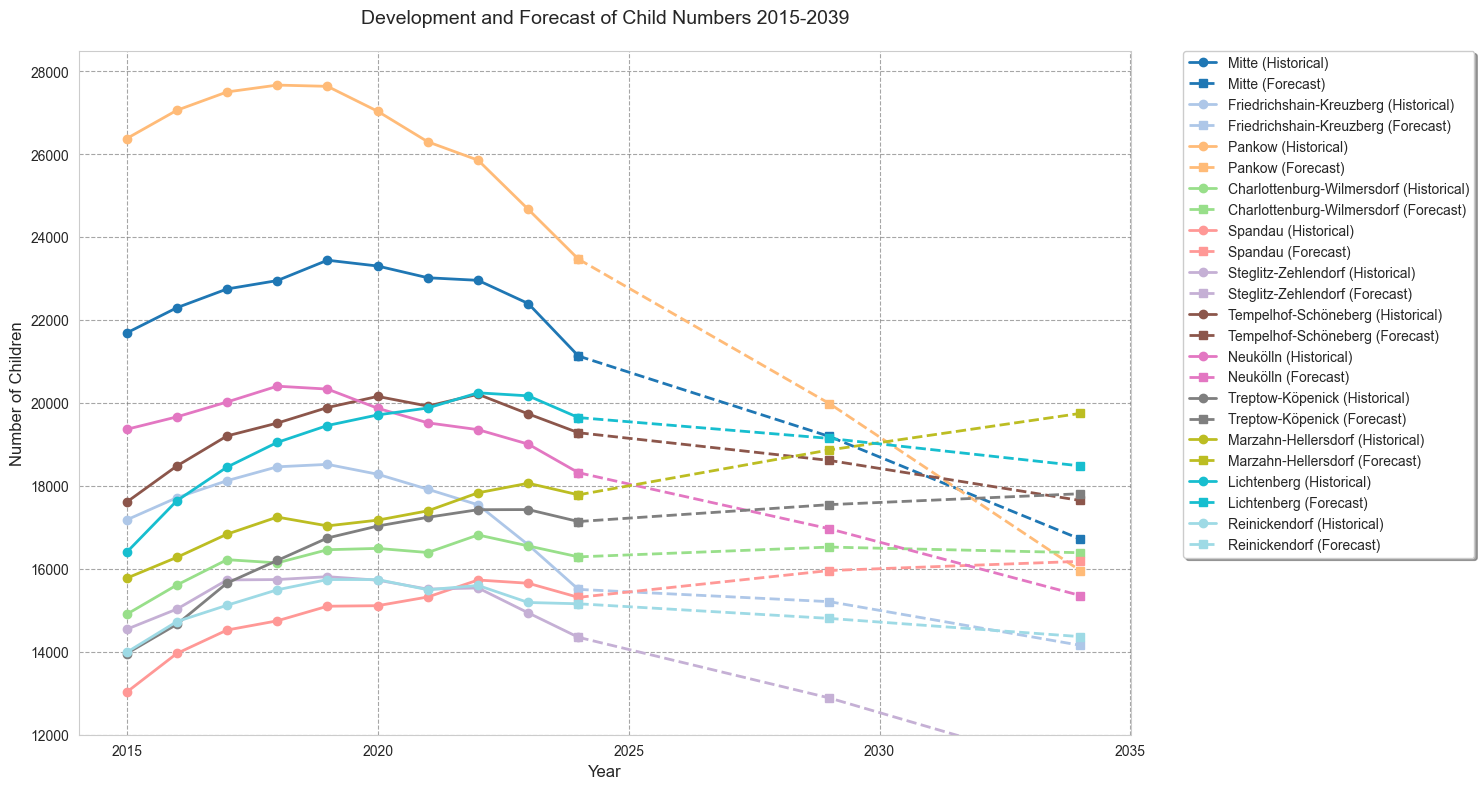

In [10]:
# Round results to whole numbers and save
results = results.astype(int)

# Save results as CSV
results.to_csv(OUTPUT_PATH)

# Output the save path
print(f"\nForecast saved in: {OUTPUT_PATH}")

plt.figure(figsize=(15, 8))

# Define colors for each district
colors = plt.cm.tab20(np.linspace(0, 1, len(df['Bezirk'])))

# Plot historical data and forecasts for each district
for idx, bezirk in enumerate(df['Bezirk']):
        # Historical data
        historical_values = df[df['Bezirk'] == bezirk].iloc[0, 1:].values
        historical_years = list(range(2015, 2025))
        
        # Forecast values
        forecast_values = results.loc[bezirk]
        all_years = results.columns.astype(int)
        
        # Plot with the same color for historical and forecast
        plt.plot(historical_years, historical_values, 
                marker='o', 
                linestyle='-', 
                color=colors[idx],
                linewidth=2,
                label=f'{bezirk} (Historical)')
        
        plt.plot(all_years, forecast_values, 
                marker='s', 
                linestyle='--', 
                color=colors[idx],
                linewidth=2,
                label=f'{bezirk} (Forecast)')

plt.title('Development and Forecast of Child Numbers 2015-2039', pad=20, size=14)
plt.xlabel('Year', size=12)
plt.ylabel('Number of Children', size=12)

# Set x-axis ticks to show whole years
plt.xticks(range(2015, 2040, 5))  # Show years in 5-year intervals
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Adjust grid
plt.grid(True, linestyle='--', alpha=0.7, color='gray', zorder=0)

# Adjust axis range
plt.ylim(bottom=12000)  # Adjust lower bound

# Optimize legend
plt.legend(bbox_to_anchor=(1.05, 1), 
                loc='upper left', 
                borderaxespad=0,
                frameon=True,
                fancybox=True,
                shadow=True,
                fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()